This is going to take the architecture from the previous notebook and reduce the regularization.
This should help reduce underfitting.

Graphing the performance will also help.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

from src.models.train_model import load_data
from src.models.predict_model import submission
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

In [3]:
defaults.cmap='binary'

In [4]:
data = load_data(TRAIN_FOLDER, batch_size=256)

### Create the Model

Turns out that the custom model doesn't support the regularization parameter I was looking for, so lets just start adding regularization layers.
It was also missing the non linearity which is a shame.

In [5]:
class Skip(nn.Module):
    """ 2 convolutions followed by adding to the input (skip) """
    def __init__(self, size):
        super().__init__()
        self.conv_1 = conv_layer(size, size, stride=1, use_activ=True, leaky=0.1)
        self.conv_2 = conv_layer(size, size, stride=1, use_activ=True, leaky=0.1)
        self.bn = nn.BatchNorm2d(size)
        self.dropout = nn.Dropout()
        self.relu = nn.LeakyReLU()
    
    def forward(self, x):
        out = x
        for layer in [
            self.bn, self.dropout, self.conv_1, self.conv_2
        ]:
            out = layer(out)
        out = x + out
        out = self.relu(out)
        return out

In [6]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [7]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [8]:
model = nn.Sequential(
    conv2(1, 8),
    Skip(8),
    conv2(8, 16),
    Skip(16),
    conv2(16, 32),
    Skip(32),
    conv2(32, 16),
    Skip(16),
    conv2(16, 10),
    Flatten()
)

In [9]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Skip(
    (conv_1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.1, inplace)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.1, inplace)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2,

In [14]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [15]:
learn.fit_one_cycle(10, max_lr=0.1)

In [16]:
learn.save('07-regularization-1')

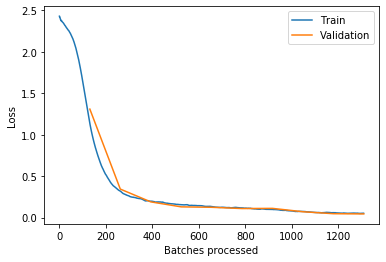

In [18]:
learn.recorder.plot_losses()

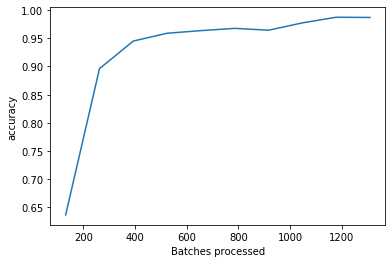

In [19]:
learn.recorder.plot_metrics()

Holy shit.
This is so much faster to train and already gets better accuracy!
It still underfits because the training loss is less than the valid loss.

Lets increase the batch size and try training for longer.

In [20]:
data = load_data(TRAIN_FOLDER, batch_size=1024)

In [21]:
model = nn.Sequential(
    conv2(1, 8),
    Skip(8),
    conv2(8, 16),
    Skip(16),
    conv2(16, 32),
    Skip(32),
    conv2(32, 16),
    Skip(16),
    conv2(16, 10),
    Flatten()
)

In [22]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-01
Min loss divided by 10: 3.31E-01


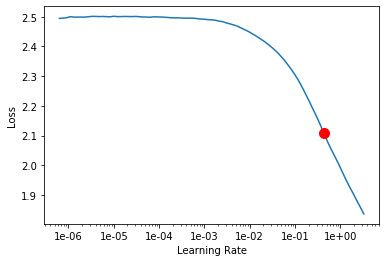

In [24]:
learn.recorder.plot(suggestion=True)

In [25]:
learn.fit_one_cycle(50, max_lr=0.1)

In [26]:
learn.save('07-regularization-2')

### Submission

This is way better now. Lets submit it!

I just checked the numbers from before. This is not better :(
I need to beat 99.457%

Lets try altering some of the regularization.
The problem is that `conv_layer` already has regularization. I should tune that instead.

In [4]:
class Skip(nn.Module):
    """ 2 convolutions followed by adding to the input (skip) """
    def __init__(self, size):
        super().__init__()
        self.conv_1 = conv_layer(size, size, stride=1, use_activ=True, leaky=0.1, self_attention=True)
        self.conv_2 = conv_layer(size, size, stride=1, use_activ=True, leaky=0.1, self_attention=True)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        out = x
        for layer in [
            self.dropout, self.conv_1, self.dropout, self.conv_2
        ]:
            out = layer(out)
        return x + out

def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [30]:
??conv_layer

Signature:
conv_layer(
    ni: int,
    nf: int,
    ks: int = 3,
    stride: int = 1,
    padding: int = None,
    bias: bool = None,
    is_1d: bool = False,
    norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>,
    use_activ: bool = True,
    leaky: float = None,
    transpose: bool = False,
    init: Callable = <function kaiming_normal_ at 0x7fb89dcd6d90>,
    self_attention: bool = False,
)
Source:   
def conv_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is No

In [31]:
??SelfAttention

Init signature: SelfAttention(n_channels: int)
Source:        
class SelfAttention(Module):
    "Self attention layer for nd."
    def __init__(self, n_channels:int):
        self.query = conv1d(n_channels, n_channels//8)
        self.key   = conv1d(n_channels, n_channels//8)
        self.value = conv1d(n_channels, n_channels)
        self.gamma = nn.Parameter(tensor([0.]))

    def forward(self, x):
        #Notation from https://arxiv.org/pdf/1805.08318.pdf
        size = x.size()
        x = x.view(*size[:2],-1)
        f,g,h = self.query(x),self.key(x),self.value(x)
        beta = F.softmax(torch.bmm(f.permute(0,2,1).contiguous(), g), dim=1)
        o = self.gamma * torch.bmm(h, beta) + x
        return o.view(*size).contiguous()
File:           ~/.local/share/virtualenvs/digit-recognizer-1OQ1lSOx/lib/python3.7/site-packages/fastai/layers.py
Type:           PrePostInitMeta
Subclasses:     


In [5]:
data = load_data(TRAIN_FOLDER, batch_size=1024 * 2)

In [6]:
model = nn.Sequential(
    conv2(1, 8),
    Skip(8),
    conv2(8, 16),
    Skip(16),
    conv2(16, 32),
    Skip(32),
    conv2(32, 16),
    Skip(16),
    conv2(16, 10),
    Flatten()
)

In [7]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 3.31E-01


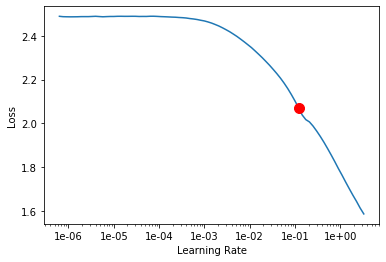

In [8]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [9]:
learn.fit_one_cycle(25, max_lr=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 5.25E-04


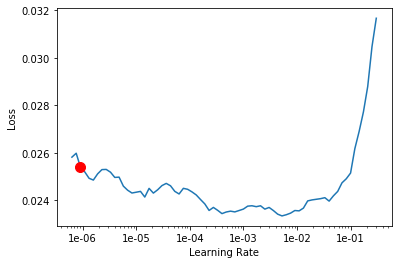

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
learn.fit_one_cycle(25, max_lr=1E-4)

In [12]:
learn.fit_one_cycle(25, max_lr=1E-3)

was: `1686 Matthew Franglen 0.98271`<br/>
was: `0731 Matthew Franglen 0.99428`<br/>
was: `0694 Matthew Franglen 0.99457`<br/>
now: `xxxx Matthew Franglen 0.99300`

So using dropout was not an improvement. It also does not appear to be overfitting.